In [ ]:
!pip install -U keras-tuner

In [1]:
import pandas as pd
import numpy as np
import glob, os
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.metrics import AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
import matplotlib.pyplot as pyplot
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
trades_dir = "../symphony/backtest/backtests/results/test_results/Oanda/OptimizedStrategy/1ATR/"

In [3]:
test_dirs = glob.glob(trades_dir + "*/*/")

In [4]:
file_id_list = [
        (os.path.dirname(filename), int(os.path.basename(filename).split(".")[0]))
        for test_dir in test_dirs
        for filename in glob.glob(test_dir + "*.csv") 
        
    ]
file_id_list = sorted(file_id_list, key=lambda tup: tup[1])

In [5]:
data_files, label_files = [], []

for path, file_id in file_id_list:
    data_files.append(os.path.join(path, str(file_id)) + ".csv")
    label_files.append(os.path.join(path, str(file_id)) + ".meta")


In [6]:
print(data_files[0])
print(label_files[0])

../symphony/backtest/backtests/results/test_results/Oanda/OptimizedStrategy/1ATR/USDCAD/USDCAD60/1357524000.csv
../symphony/backtest/backtests/results/test_results/Oanda/OptimizedStrategy/1ATR/USDCAD/USDCAD60/1357524000.meta


In [35]:
input_dfs = []
cols_to_use = ["opens","highs","lows","closes","volumes"]
for i,datafile in enumerate(data_files):
    data = pd.read_csv(datafile)
    data = data[cols_to_use]
    input_dfs.append(data.fillna(0))

In [36]:
input_dfs[0].head()

,opens,highs,lows,closes,volumes
0,0.98596,0.98670,0.98556,0.98668,737.0
1,0.98666,0.98682,0.98619,0.98676,816.0
2,0.98674,0.98675,0.98452,0.98464,1709.0
3,0.98465,0.98570,0.98460,0.98538,999.0
4,0.98538,0.98625,0.98482,0.98505,1792.0


In [37]:
NUM_FEATURES = len(input_dfs[0].columns)

In [38]:
df_list = [pd.read_csv(filename) for filename in label_files]
all_labels = pd.concat(df_list, ignore_index=True)
all_labels.head()

,profitable,profit_in_pips,profit_factor,instrument,order_type,datetime,posix_time
0,0,0,149.149547,USDCAD,sell,2013-01-07 03:00:00,1357524000
1,1,524,0.589695,AUDUSD,sell,2013-01-08 08:00:00,1357628400
2,0,-1054,3.688811,NZDUSD,sell,2013-01-10 14:00:00,1357822800
3,0,-114,0.080402,AUDUSD,sell,2013-01-16 06:00:00,1358312400
4,1,502,1.308151,USDCHF,sell,2013-01-17 23:00:00,1358460000


In [39]:
buy_indices = all_labels.index[all_labels['order_type'] == "buy"].tolist()
sell_indices = all_labels.index[all_labels['order_type'] == "sell"].tolist()
buy_labels = all_labels.loc[all_labels['order_type'] == "buy"]["profitable"].values
sell_labels = all_labels.loc[all_labels['order_type'] == "sell"]["profitable"].values
buy_profits = all_labels.loc[all_labels['order_type'] == "buy"]["profit_in_pips"].values
sell_profits = all_labels.loc[all_labels['order_type'] == "sell"]["profit_in_pips"].values
buy_inputs = [input_dfs[i] for i in buy_indices]
sell_inputs = [input_dfs[i] for i in sell_indices]

In [40]:
print("% Profitable BUY: {}".format(list(buy_labels).count(1) / len(buy_labels)))
print("% Profitable SELL: {}".format(list(sell_labels).count(1) / len(sell_labels)))

% Profitable BUY: 0.39642324888226527
% Profitable SELL: 0.5347744360902256


In [41]:
class MinMaxer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        scaler = MinMaxScaler(feature_range=(0.0001, 1.0))
        for df in inputs:
            df[df.columns] = scaler.fit_transform(df[df.columns])
        return inputs

    def fit(self, inputs):
        pass


In [42]:
class ListOfNumpy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, inputs):
        
        return [inp.to_numpy() for inp in inputs]

    def fit(self, inputs):
        pass

In [43]:
pipe = Pipeline(
            steps=
            [
                ('min_max',MinMaxer()),
                #('transpose', Transposer()),
                #('zero_pad',ZeroPad()),
                ('list_of_numpy', ListOfNumpy())
            ])

In [44]:
buy_data_pipelined = pipe.transform(buy_inputs)
sell_data_pipelined = pipe.transform(sell_inputs)



In [45]:
buy_data_pipelined[0].head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
print(buy_data_pipelined[0].shape)


In [ ]:

# Adopt a different train test split strategy that doubles as forward testing.
# -> Find the index whereat 80% of the trades lies before, use that as training.

train_perc = 0.8
buy_stop_index = round(len(buy_labels) * train_perc)
X_buy_train = buy_data_pipelined[:buy_stop_index]
X_buy_test = buy_data_pipelined[buy_stop_index:]
y_buy_train = buy_labels[:buy_stop_index]
y_buy_test = buy_labels[buy_stop_index:]
profit_buy_train = buy_profits[:buy_stop_index]
profit_buy_test = buy_profits[buy_stop_index:]


sell_stop_index = round(len(sell_labels) * train_perc)
X_sell_train = sell_data_pipelined[:sell_stop_index]
X_sell_test = sell_data_pipelined[sell_stop_index:]
y_sell_train = sell_labels[:sell_stop_index]
y_sell_test = sell_labels[sell_stop_index:]
profit_sell_train = buy_profits[:sell_stop_index]
profit_sell_test = buy_profits[sell_stop_index:]


In [ ]:
print(X_buy_train[0])

In [ ]:
def get_length_dict(inputs):
    train_data_cpy = inputs.copy()
    all_lengths = list(set([len(item) for item in train_data_cpy]))
    length_indices = [None] * len(all_lengths)
    
    for i, length in enumerate(all_lengths):
        identified_indices = []
        for j, item in enumerate(train_data_cpy):
            if len(item) == length:
                identified_indices.append(j)
        length_indices[i] = identified_indices
    return dict(zip(all_lengths, length_indices))
    """
    all_lengths = list(set([len(item[0]) for item in train_data_cpy]))
    length_indices = [None] * len(all_lengths)
    for i, length in enumerate(all_lengths):
        identified_indices = []
        for j, item in enumerate(train_data_cpy):
            if len(item[0]) == length:
                identified_indices.append(j)
        length_indices[i] = identified_indices
        
    return dict(zip(all_lengths, length_indices))
    """
    
def train_generator(inputs, labels, length_dict):
    train_data_cpy = inputs.copy()
    labels_cpy = labels.copy()
    while True:
        for length, indices in length_dict.items():
            batch = np.array([train_data_cpy[i] for i in indices])
            batch_labels = np.array([labels_cpy[i] for i in indices])
            yield batch, batch_labels


        

In [ ]:
length_dict_train = get_length_dict(X_buy_train)
length_dict_test = get_length_dict(X_buy_test)

steps_per_epoch_train = len(length_dict_train.keys())
steps_per_epoch_test = len(length_dict_test.keys())

In [ ]:
print(steps_per_epoch_train)


In [ ]:
def precision_recall(model, X_test: list, y_test: list, profits: list, verbose=True, threshold=0.5) -> tuple:
    true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
    positives, negatives = list(y_test).count(1), list(y_test).count(0)
    
    print("Analyzing {} samples".format(len(y_test)))
    print("Threshold: {}".format(threshold))
    profit = 0
    for i, (inp, label) in enumerate(zip(X_test, y_test)):
        #print(inp)
        #inp = inp.reshape(1, X_test.shape[1], X_test.shape[2])
        prob_prediction = model.predict([[inp]], batch_size=1, steps=1)[0][0]
        class_prediction = model.predict_classes([[inp]], batch_size=1)[0][0]
        
        
        is_predicted_profitable = True if prob_prediction > threshold else False
        
        if is_predicted_profitable:
            print("Profit: {}".format(profits[i]))
            profit += profits[i]
        
        
        if is_predicted_profitable and label:
            true_positives += 1
        elif not is_predicted_profitable and not label:
            true_negatives += 1
        elif is_predicted_profitable and not label:
            false_positives += 1
        elif not is_predicted_profitable and label:
            false_negatives += 1
            print("False Negative, prob: {}".format(prob_prediction))
        else:
            raise Exception("Error!")
            
    if not true_positives + false_positives:
        precision = 0
    else:
        precision = true_positives / (true_positives + false_positives)
        
    if not true_positives + false_negatives:
        recall = 0
    else:
        recall = true_positives / (true_positives + false_negatives)
        
    if verbose:
        print("The model guessed:")
        print("\t{}/{} profitable trades correctly (true positives)".format(true_positives, positives))
        print("\t{}/{} profitable trades incorrectly (false negatives)".format(false_negatives, positives))
        print("\t{}/{} unprofitable trades correctly (true negatives)".format(true_negatives, negatives))
        print("\t{}/{} unprofitable trades incorrectly (false positives)".format(false_positives, negatives))
        print("\t Precision: {}".format(precision))
        print("\t Recall: {}".format(recall))
        print("\t Profit: {}".format(profit))
    return (precision, recall)



# Stacked Bidirectional

In [46]:
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True), input_shape=(None, NUM_FEATURES)))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit_generator(train_generator(X_buy_train, y_buy_train, length_dict_train), steps_per_epoch=steps_per_epoch_train, epochs=10, verbose=1)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, None, 200)         84800     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         240800    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 566,601
Trainable params: 566,601
Non-trainable params: 0
_________________________________________________________________
None
Train for 66 steps
Epoch 1/10
 1/66 [..............................] - ETA: 183:51:21

InvalidArgumentError:  Specified a list with shape [?,5] from a tensor with shape [1,14]
	 [[node sequential_1/bidirectional_3/forward_lstm_3/TensorArrayUnstack/TensorListFromTensor (defined at <ipython-input-46-a8bc1e47eeca>:8) ]] [Op:__inference_distributed_function_144475]

Function call stack:
distributed_function


In [ ]:
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.45)     

# Variable Length Batch Sizes

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 75)                27000     
_________________________________________________________________
dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 76        
Total params: 27,076
Trainable params: 27,076
Non-trainable params: 0
_________________________________________________________________
None
Train for 66 steps
Epoch 1/10
66/66 [==============================] - 7s 110ms/step - loss: 0.6931 - accuracy: 0.5345
Epoch 2/10
66/66 [==============================] - 4s 68ms/step - loss: 0.6652 - accuracy: 0.5959
Epoch 3/10
66/66 [==============================] - 4s 57ms/step - loss: 0.6724 - accuracy: 0.5829
Epoch 4/10
66/66 [==============================] - 4s 56ms/

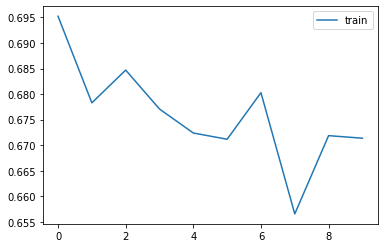

In [40]:
model = Sequential()
# Timesteps x features (https://stackoverflow.com/questions/53496095/keras-reports-typeerror-unsupported-operand-types-for-nonetype-and-int)
model.add(LSTM(75, input_shape=(None, NUM_FEATURES), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit_generator(train_generator(X_buy_train, y_buy_train, length_dict_train), steps_per_epoch=steps_per_epoch_train, epochs=10, verbose=1)

# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()
scores = model.evaluate_generator(train_generator(X_buy_test, y_buy_test, length_dict_test), steps=steps_per_epoch_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


In [41]:

precision_recall(model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.45)     

Analyzing 134 samples
Threshold: 0.45
False Negative, prob: 0.3201195001602173
False Negative, prob: 0.39100730419158936
Profit: -703
Profit: -856
False Negative, prob: 0.3419395685195923
False Negative, prob: 0.19698646664619446
Profit: -571
False Negative, prob: 0.42123377323150635
False Negative, prob: 0.28027597069740295
Profit: -805
False Negative, prob: 0.31793826818466187
Profit: 975
False Negative, prob: 0.2740282416343689
False Negative, prob: 0.3083304166793823
Profit: -335
Profit: 1222
False Negative, prob: 0.20337741076946259
False Negative, prob: 0.3476145565509796
Profit: -151
False Negative, prob: 0.386900931596756
Profit: -1062
Profit: 231
Profit: -302
False Negative, prob: 0.3776143789291382
False Negative, prob: 0.1930251270532608
False Negative, prob: 0.2029196172952652
Profit: -213
False Negative, prob: 0.28590095043182373
Profit: -402
Profit: -482
False Negative, prob: 0.2530164122581482
False Negative, prob: 0.2371106892824173
Profit: 1004
False Negative, prob: 0.

(0.25806451612903225, 0.2222222222222222)

# Stacked LSTM

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, None, 100)         42800     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 100)         80400     
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

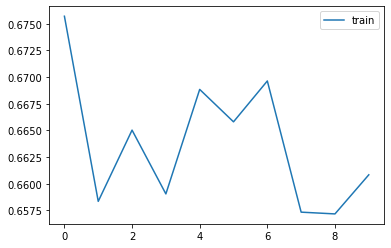

In [351]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(None, NUM_FEATURES), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit_generator(train_generator(X_buy_train, y_buy_train, length_dict_train), steps_per_epoch=steps_per_epoch_train, epochs=10, verbose=1)

# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test') # Only when using validation set
pyplot.legend()

scores = model.evaluate_generator(train_generator(X_buy_test, y_buy_test, length_dict_test), steps=steps_per_epoch_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [353]:
precision_recall(model, X_buy_test, y_buy_test, profit_buy_test, threshold=0.5)

Analyzing 104 samples
Threshold: 0.5
False Negative, prob: 0.4354161024093628
False Negative, prob: 0.44973239302635193
False Negative, prob: 0.3566049337387085
False Negative, prob: 0.488686740398407
False Negative, prob: 0.39016056060791016
False Negative, prob: 0.4911869168281555
False Negative, prob: 0.3722400963306427
False Negative, prob: 0.425231397151947
False Negative, prob: 0.40623587369918823
False Negative, prob: 0.47498705983161926
False Negative, prob: 0.3309614956378937
False Negative, prob: 0.424811989068985
False Negative, prob: 0.459574818611145
False Negative, prob: 0.46504953503608704
False Negative, prob: 0.44093841314315796
False Negative, prob: 0.48840340971946716
False Negative, prob: 0.43271011114120483
False Negative, prob: 0.45117032527923584
False Negative, prob: 0.4825085997581482
False Negative, prob: 0.4661663770675659
False Negative, prob: 0.4282458424568176
False Negative, prob: 0.4453393518924713
False Negative, prob: 0.4707343280315399
False Negative,

(0, 0.0)